<a href="https://colab.research.google.com/github/Alikerin/Introduction-to-Data-Centric-AI/blob/main/Introduction_to_Data_Centric_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This notebook contains the code for the "Introduction to Data-Centric AI" workshop hosted at [AMLD Africa 2022](https://appliedmldays.org/events/amld-africa-2022).

In this notebook we would solve the first [Data-Centric AI Competition](https://https-deeplearning-ai.github.io/data-centric-comp/) organized by Deep Learning.AI and Landing AI.


In [21]:
#@title Download Data
import gdown

!rm -rf data_label_corrected
!rm -rf data_label_corrected_mcd
!rm -rf data
!rm -rf label_book
!rm -rf __MACOSX

gdown.download(id="1hfkG1MR0sHqERFTWY986IA8ASgioT111", output='data_label_corrected.tar.gz', quiet=True)
gdown.download(id="102nKEEf8rfdaz9H4rGC7oNWTOOevZnCQ", output='data.tar.gz', quiet=True)
gdown.download(id="1HnVydTwTUv-ZkFX-6NGXvxR_6rWRxHBI", output='label_book.tar.gz', quiet=True)
gdown.download(id="1lVs82t1A_2vmeQKJ585kZhfVfuU59D5O", output='data_label_corrected_mcd.zip', quiet=True)

!tar -xzf data_label_corrected.tar.gz
!tar -xzf data.tar.gz
!tar -xzf label_book.tar.gz
!unzip -q data_label_corrected_mcd.zip

!rm data_label_corrected.tar.gz
!rm data_label_corrected_mcd.zip
!rm data.tar.gz
!rm label_book.tar.gz

In [2]:
#@title Install Packages
!pip -q install dvc[gdrive]


     |████████████████████████████████| 401 kB 5.1 MB/s 
     |████████████████████████████████| 291 kB 52.7 MB/s 
     |████████████████████████████████| 109 kB 63.8 MB/s 
     |████████████████████████████████| 44 kB 3.0 MB/s 
     |████████████████████████████████| 237 kB 65.3 MB/s 
     |████████████████████████████████| 44 kB 3.3 MB/s 
     |████████████████████████████████| 40 kB 6.9 MB/s 
     |████████████████████████████████| 42 kB 1.4 MB/s 
     |████████████████████████████████| 182 kB 73.6 MB/s 
     |████████████████████████████████| 498 kB 67.3 MB/s 
     |████████████████████████████████| 346 kB 71.4 MB/s 
     |████████████████████████████████| 4.5 MB 60.9 MB/s 
     |████████████████████████████████| 4.1 MB 56.1 MB/s 
     |████████████████████████████████| 140 kB 76.5 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 57 kB 5.2 MB/s 
     |████████████████████████████████| 96 kB 6.6 MB/s 
     |███████████████████████

# Part 1 - Establish a Baseline
To establish a baseline performance, we simply train the model on the original version of data

## Train and Evaluate

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import json
import sys


In [ ]:
train_val_directory = "data"
test_directory = "label_book"

batch_size = 8
tf.random.set_seed(123)

labels = ["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"]


In [ ]:
train = tf.keras.preprocessing.image_dataset_from_directory(
    train_val_directory + '/train',
    labels="inferred",
    label_mode="categorical",
    class_names=labels,
    shuffle=True,
    seed=123,
    batch_size=batch_size,
    image_size=(32, 32),
)

valid = tf.keras.preprocessing.image_dataset_from_directory(
    train_val_directory + '/val',
    labels="inferred",
    label_mode="categorical",
    class_names=labels,
    shuffle=False,
    seed=123,
    batch_size=batch_size,
    image_size=(32, 32),
)

total_length = ((train.cardinality() + valid.cardinality()) * batch_size).numpy()
if total_length > 10_000:
    print(f"Dataset size larger than 10,000. Got {total_length} examples")
    sys.exit()

test = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory,
    labels="inferred",
    label_mode="categorical",
    class_names=labels,
    shuffle=False,
    seed=123,
    batch_size=batch_size,
    image_size=(32, 32),
)

Found 2067 files belonging to 10 classes.
Found 813 files belonging to 10 classes.
Found 52 files belonging to 10 classes.


In [ ]:
base_model = tf.keras.applications.ResNet50(
    input_shape=(32, 32, 3),
    include_top=False,
    weights=None,
)
base_model = tf.keras.Model(
    base_model.inputs, outputs=[base_model.get_layer("conv2_block3_out").output]
)

inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.applications.resnet.preprocess_input(inputs)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(10)(x)
model = tf.keras.Model(inputs, x)

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 tf.__operators__.getitem (S  (None, 32, 32, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 32, 32, 3)        0         
                                                                 
 model (Functional)          (None, 8, 8, 256)         229760    
                                                                 
 global_average_pooling2d (G  (None, 256)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 10)                2570

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "ckpt_part_1/best_model",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    save_weights_only=True,
)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

history = model.fit(
    train,
    validation_data=valid,
    epochs=100,
    callbacks=[checkpoint, early_stopping],
)

Epoch 1/100
259/259 [==============================] - 18s 16ms/step - loss: 2.0193 - accuracy: 0.2941 - val_loss: 1.9539 - val_accuracy: 0.2362
Epoch 2/100
259/259 [==============================] - 4s 14ms/step - loss: 1.4691 - accuracy: 0.5259 - val_loss: 1.5672 - val_accuracy: 0.4256
Epoch 3/100
259/259 [==============================] - 4s 14ms/step - loss: 1.2227 - accuracy: 0.6067 - val_loss: 1.2651 - val_accuracy: 0.5572
Epoch 4/100
259/259 [==============================] - 4s 14ms/step - loss: 1.0207 - accuracy: 0.6783 - val_loss: 1.2230 - val_accuracy: 0.5584
Epoch 5/100
259/259 [==============================] - 4s 14ms/step - loss: 0.8845 - accuracy: 0.7209 - val_loss: 1.0808 - val_accuracy: 0.6421
Epoch 6/100
259/259 [==============================] - 5s 18ms/step - loss: 0.7898 - accuracy: 0.7547 - val_loss: 1.1367 - val_accuracy: 0.5929
Epoch 7/100
259/259 [==============================] - 4s 14ms/step - loss: 0.7105 - accuracy: 0.7837 - val_loss: 1.1249 - val_accuracy

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

def evaluate_model(model, dataset):
    labels = np.concatenate([y.numpy() for x, y in dataset], axis=0).argmax(axis=1)
    pred_labels = np.argmax(model.predict(dataset), axis=1)
    cm = confusion_matrix(labels, pred_labels)
    acc = accuracy_score(labels, pred_labels)
    return acc, cm

def show_confusion_matrix(cm, labels):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
                annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()

In [ ]:
model.load_weights("ckpt_part_1/best_model")

102/102 [==============================] - 1s 7ms/step
Validation Accuracy: 0.6605166051660517


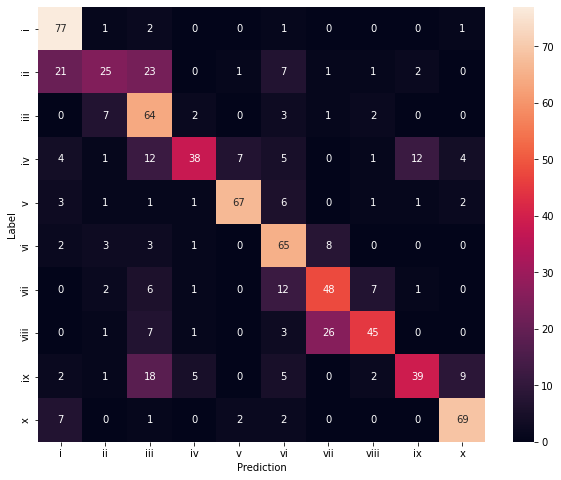

In [ ]:
val_acc, val_cm = evaluate_model(model, valid)
print(f"Validation Accuracy: {val_acc}")
show_confusion_matrix(val_cm, labels)


7/7 [==============================] - 0s 18ms/step
Test Accuracy: 0.5384615384615384


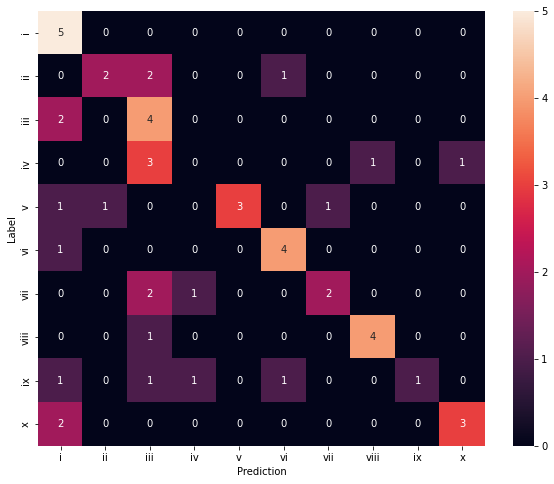

In [ ]:
test_acc, test_cm = evaluate_model(model, test)
print(f"Test Accuracy: {test_acc}")
show_confusion_matrix(test_cm, labels)


## Track Data with DVC
To keep track of data provenance, we commit data as code using [DVC](https://dvc.org/). To learn more about DVC, check this [tutorial](https://dvc.org/doc/use-cases/versioning-data-and-models/tutorial).

We would begin by committing the first version of the data

In [ ]:
!git init
!git config --global user.email "i.yusuf@instadeep.com"
!git config --global user.name "Ibrahim Salihu Yusuf"

In [ ]:
!dvc init

Initialized DVC repository.

You can now commit the changes to git.

+---------------------------------------------------------------------+
|                                                                     |
|        DVC has enabled anonymous aggregate usage analytics.         |
|     Read the analytics documentation (and how to opt-out) here:     |
|             <https://dvc.org/doc/user-guide/analytics>              |
|                                                                     |
+---------------------------------------------------------------------+

What's next?
------------
- Check out the documentation: <https://dvc.org/doc>
- Get help and share ideas: <https://dvc.org/chat>
- Star us on GitHub: <https://github.com/iterative/dvc>


In [ ]:
# Track data directory
!dvc add data

In [ ]:
!ls

ckpt_part_1  data  data.dvc  data_label_corrected  label_book  sample_data


In [ ]:
!cat data.dvc

outs:
- md5: fe024fe75f5f74a6a1669c08a3e2d2de.dir
  size: 5960945
  nfiles: 2884
  path: data


In [ ]:
!git add data.dvc
!git commit -m "add version_1 data"

[master (root-commit) fccb847] add version_1 data
 4 files changed, 11 insertions(+)
 create mode 100644 .dvc/.gitignore
 create mode 100644 .dvc/config
 create mode 100644 .dvcignore
 create mode 100644 data.dvc


In [ ]:
# Store the data remotely
# !dvc remote add -d remote gdrive://1a4AbZ8izazFzPdPD471HqIBMxO2ut6gc #
!dvc remote add -d local_remote /tmp/dvcstore

Setting 'local_remote' as a default remote.


In [ ]:
!cat .dvc/config

[core]
    remote = local_remote
['remote "remote"']
    url = gdrive://1a4AbZ8izazFzPdPD471HqIBMxO2ut6gc
['remote "local_remote"']
    url = /tmp/dvcstore


In [ ]:
!dvc push

# Part 2 - Apply Data Augmentation

Data augmentation is a process of applying a set of pertubabtion to data samples while preserving the mapping from x -> y.

In this part, we would apply rotation, translation and zoom perturbations to each image in an offline manner.

In [4]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import json
import sys
import os

In [5]:
train_val_directory = "data"
test_directory = "label_book"

batch_size = 8
tf.random.set_seed(123)

labels = ["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"]

## Data Augmentation

We generated **three** augmented samples for each original sample.

In [22]:
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import glob

datagen = ImageDataGenerator(
    rotation_range=30,          # randomly rotate image by upto 30 deg
    width_shift_range=0.2,      # randomly shift along x 
    height_shift_range=0.2,     # randomly shift along y
    zoom_range=0.1,             # zooming
    fill_mode='nearest')

for label in labels:
    i = 0
    input_dir = f'data/train/{label}'
    image_list = glob.glob(f"{input_dir}/*.png")
    image_array = np.array([np.array(Image.open(image_name).resize((32, 32)))[:, :, np.newaxis] for image_name in image_list])
    out_dir = 'aug' #f'data/train/{label}'
    os.makedirs(out_dir, exist_ok=True)
    max_images = len(image_array)*3
    for batch in datagen.flow(image_array, batch_size=batch_size,
                            save_to_dir= out_dir,
                            save_prefix='aug',
                            save_format='png'):
        break    
        i+=len(batch)
        if i > max_images:
            break

## Train and Evaluate

In [ ]:
train = tf.keras.preprocessing.image_dataset_from_directory(
    train_val_directory + '/train',
    labels="inferred",
    label_mode="categorical",
    class_names=labels,
    shuffle=True,
    seed=123,
    batch_size=batch_size,
    image_size=(32, 32),
)

valid = tf.keras.preprocessing.image_dataset_from_directory(
    train_val_directory + '/val',
    labels="inferred",
    label_mode="categorical",
    class_names=labels,
    shuffle=False,
    seed=123,
    batch_size=batch_size,
    image_size=(32, 32),
)

total_length = ((train.cardinality() + valid.cardinality()) * batch_size).numpy()
if total_length > 10_000:
    print(f"Dataset size larger than 10,000. Got {total_length} examples")
    sys.exit()

test = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory,
    labels="inferred",
    label_mode="categorical",
    class_names=labels,
    shuffle=False,
    seed=123,
    batch_size=batch_size,
    image_size=(32, 32),
)

Found 8348 files belonging to 10 classes.
Found 813 files belonging to 10 classes.
Found 52 files belonging to 10 classes.


In [ ]:
base_model = tf.keras.applications.ResNet50(
    input_shape=(32, 32, 3),
    include_top=False,
    weights=None,
)
base_model = tf.keras.Model(
    base_model.inputs, outputs=[base_model.get_layer("conv2_block3_out").output]
)

inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.applications.resnet.preprocess_input(inputs)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(10)(x)
model = tf.keras.Model(inputs, x)

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 tf.__operators__.getitem_2   (None, 32, 32, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 32, 32, 3)        0         
 a)                                                              
                                                                 
 model_4 (Functional)        (None, 8, 8, 256)         229760    
                                                                 
 global_average_pooling2d_2   (None, 256)              0         
 (GlobalAveragePooling2D)                                        
                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "ckpt_part_2/best_model",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    save_weights_only=True,
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

history = model.fit(
    train,
    validation_data=valid,
    epochs=100,
    callbacks=[checkpoint, early_stopping],
)

Epoch 1/100
1044/1044 [==============================] - 14s 12ms/step - loss: 1.7933 - accuracy: 0.3789 - val_loss: 1.4681 - val_accuracy: 0.4822
Epoch 2/100
1044/1044 [==============================] - 11s 10ms/step - loss: 1.2990 - accuracy: 0.5696 - val_loss: 1.4929 - val_accuracy: 0.5141
Epoch 3/100
1044/1044 [==============================] - 11s 11ms/step - loss: 1.0652 - accuracy: 0.6499 - val_loss: 1.0289 - val_accuracy: 0.6236
Epoch 4/100
1044/1044 [==============================] - 11s 11ms/step - loss: 0.9212 - accuracy: 0.7046 - val_loss: 0.8969 - val_accuracy: 0.6581
Epoch 5/100
1044/1044 [==============================] - 12s 11ms/step - loss: 0.8179 - accuracy: 0.7351 - val_loss: 0.7913 - val_accuracy: 0.7331
Epoch 6/100
1044/1044 [==============================] - 12s 11ms/step - loss: 0.7238 - accuracy: 0.7705 - val_loss: 1.1250 - val_accuracy: 0.6335
Epoch 7/100
1044/1044 [==============================] - 12s 11ms/step - loss: 0.6604 - accuracy: 0.7881 - val_loss: 0

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

def evaluate_model(model, dataset):
    labels = np.concatenate([y.numpy() for x, y in dataset], axis=0).argmax(axis=1)
    pred_labels = np.argmax(model.predict(dataset), axis=1)
    cm = confusion_matrix(labels, pred_labels)
    acc = accuracy_score(labels, pred_labels)
    return acc, cm

def show_confusion_matrix(cm, labels):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
                annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()

In [ ]:
model.load_weights("ckpt_part_2/best_model")

102/102 [==============================] - 1s 7ms/step
Validation Accuracy: 0.7847478474784748


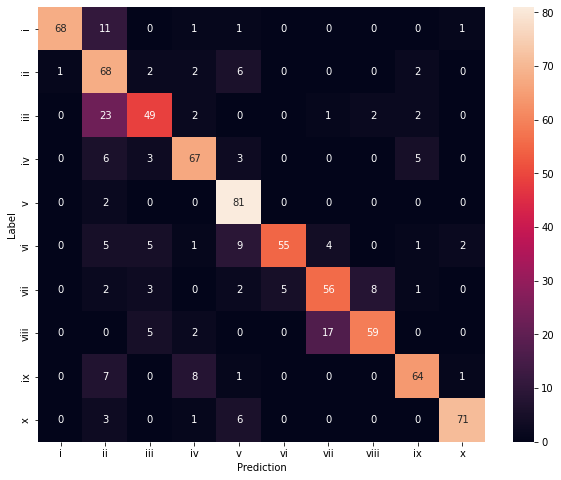

In [ ]:
val_acc, val_cm = evaluate_model(model, valid)
print(f"Validation Accuracy: {val_acc}")
show_confusion_matrix(val_cm, labels)


7/7 [==============================] - 0s 7ms/step
Test Accuracy: 0.6923076923076923


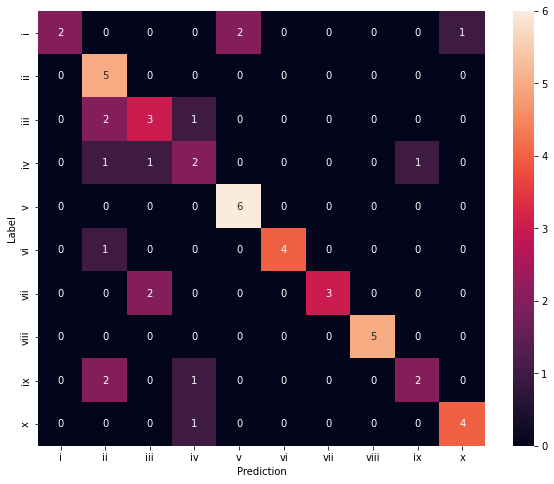

In [ ]:
test_acc, test_cm = evaluate_model(model, test)
print(f"Test Accuracy: {test_acc}")
show_confusion_matrix(test_cm, labels)


## Track Data with DVC
We commit the new version of data that has augmented samples.

In [ ]:
!dvc add data 

In [ ]:
!cat data.dvc

In [ ]:
!git add data.dvc
!git commit -m "add version_2 data"

In [ ]:
!dvc push

# Part 3 - Naïve Label Correction 
Label cleaning is an important step in improving data quality. When done naïvely, we need to go through all the images and ensure that each image has a correct label mapping. Those with incorrect mappings that can be remedied are corrected, while those that cannot be remedied are deleted. 

## Label Correction
Visual investigation of thousands of images is a herculean task. To simplify it we create a custom user interface using [ipython widgets](https://ipywidgets.readthedocs.io/en/stable/) that allows us to inpect and correct labels using button clicks.

In [11]:
import os, glob, shutil
from PIL import Image
import matplotlib.pyplot as plt


import ipywidgets as widgets
from IPython.display import display
from ipywidgets import IntProgress, HTML, VBox, HBox

In [27]:
splits = {
    "train": glob.glob(f"data/train/*/*.png"),
    "val": glob.glob(f"data/val/*/*.png"),
    "test": glob.glob("label_book/*/*.png")
}
path = None

def display_img(splits_dropdown, index):
    global label, path
    path = splits[splits_dropdown][index]
    label.value = path.split("/")[-2]
    plt.figure(figsize=(8, 8), dpi=80)
    plt.imshow(Image.open(splits[splits_dropdown][index]), cmap='gray', vmin=0, vmax=255)
    plt.axis("off")
    plt.show()

next_button = widgets.Button(
    description='Next',
    disabled=False,
    button_style='success',
    tooltip='Next Sample',
    icon='arrow-right'
)

prev_button = widgets.Button(
    description='Previous',
    disabled=False,
    button_style='success',
    tooltip='Previous Sample',
    icon='arrow-left'
)
change_label_btn = widgets.Button(
    description='Change Label',
    disabled=False,
    button_style='success',
    tooltip='Change Label',
    icon='check'
)
delete_btn = widgets.Button(
    description='Delete',
    disabled=False,
    button_style='danger',
    tooltip='Delete',
    icon='fa-trash'
)
splits_dropdown = widgets.Dropdown(
    description='Splits',
    options=['train', 'val', 'test'],
    value='train',
    disabled=False,
)

index = widgets.IntSlider(
    value=0,
    min=0,
    max=len(splits[splits_dropdown.value])-1,
    step=1,
    description='Index:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
  
label = widgets.Text(
    value='',
    placeholder='Label',
    description='Label:',
    disabled=False
)

new_label = widgets.Dropdown(
    description='New Label',
    options=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
    value='i',
    disabled=False,
)

ui_1 = widgets.HBox([prev_button, index, next_button, splits_dropdown])
ui_2 = widgets.HBox([label, new_label, change_label_btn, delete_btn])
ui = widgets.VBox([ui_1, ui_2])

interactive_out = widgets.interactive_output(display_img, {"splits_dropdown":splits_dropdown, "index": index})

def increment(_):
    with interactive_out:
        index.value+=1

def decrement(_):
    with interactive_out:
        index.value-=1

def change_label(_):
  new_path = path.split("/")
  new_path[-2] = new_label.value
  new_path = "/".join(new_path)
  shutil.move(path, new_path)

def delete_action(_):
    os.remove(path)

def update_index(_):
    index.max = len(splits[splits_dropdown.value])-1

splits_dropdown.observe(update_index)

prev_button.on_click(decrement)
next_button.on_click(increment)
change_label_btn.on_click(change_label)
delete_btn.on_click(delete_action)

display(ui, interactive_out)

Output()

## Train and Evalaute

In [14]:
!rm -rf data
!mv data_label_corrected data

In [15]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import json
import sys

In [16]:
train_val_directory = "data"
test_directory = "label_book"

batch_size = 8
tf.random.set_seed(123)

labels = ["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"]

### Data Augmentation
We apply same data augmentation used in part 1.

In [17]:
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import glob

datagen = ImageDataGenerator(
    rotation_range=30,          # randomly rotate image by upto 30 deg
    width_shift_range=0.2,      # randomly shift along x 
    height_shift_range=0.2,     # randomly shift along y
    zoom_range=0.1,             # zooming
    fill_mode='nearest')

for label in labels:
    i = 0
    input_dir = f'{train_val_directory}/train/{label}'
    image_list = glob.glob(f"{input_dir}/*.png")
    image_array = np.array([np.array(Image.open(image_name).resize((32, 32)))[:, :, np.newaxis] for image_name in image_list])
    out_dir = f'{train_val_directory}/train/{label}'
    os.makedirs(out_dir, exist_ok=True)
    max_images = len(image_array)*3
    for batch in datagen.flow(image_array, batch_size=batch_size,
                            save_to_dir= out_dir,
                            save_prefix='aug',
                            save_format='png'):    
        i+=len(batch)
        if i > max_images:
            break

In [18]:
train = tf.keras.preprocessing.image_dataset_from_directory(
    train_val_directory + '/train',
    labels="inferred",
    label_mode="categorical",
    class_names=labels,
    shuffle=True,
    seed=123,
    batch_size=batch_size,
    image_size=(32, 32),
)

valid = tf.keras.preprocessing.image_dataset_from_directory(
    train_val_directory + '/val',
    labels="inferred",
    label_mode="categorical",
    class_names=labels,
    shuffle=False,
    seed=123,
    batch_size=batch_size,
    image_size=(32, 32),
)

total_length = ((train.cardinality() + valid.cardinality()) * batch_size).numpy()
if total_length > 10_000:
    print(f"Dataset size larger than 10,000. Got {total_length} examples")
    sys.exit()

test = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory,
    labels="inferred",
    label_mode="categorical",
    class_names=labels,
    shuffle=False,
    seed=123,
    batch_size=batch_size,
    image_size=(32, 32),
)

Found 7672 files belonging to 10 classes.
Found 809 files belonging to 10 classes.
Found 52 files belonging to 10 classes.


In [19]:
base_model = tf.keras.applications.ResNet50(
    input_shape=(32, 32, 3),
    include_top=False,
    weights=None,
)
base_model = tf.keras.Model(
    base_model.inputs, outputs=[base_model.get_layer("conv2_block3_out").output]
)

inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.applications.resnet.preprocess_input(inputs)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(10)(x)
model = tf.keras.Model(inputs, x)

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 tf.__operators__.getitem_1   (None, 32, 32, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 32, 32, 3)        0         
 a)                                                              
                                                                 
 model_2 (Functional)        (None, 8, 8, 256)         229760    
                                                                 
 global_average_pooling2d_1   (None, 256)              0         
 (GlobalAveragePooling2D)                                        
                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [20]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "ckpt_part_3/best_model",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    save_weights_only=True,
)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

history = model.fit(
    train,
    validation_data=valid,
    epochs=100,
    callbacks=[checkpoint,], #early_stopping
)

Epoch 1/100
959/959 [==============================] - 13s 12ms/step - loss: 1.7556 - accuracy: 0.3859 - val_loss: 1.4200 - val_accuracy: 0.5031
Epoch 2/100
959/959 [==============================] - 13s 13ms/step - loss: 1.1687 - accuracy: 0.6126 - val_loss: 0.9279 - val_accuracy: 0.6922
Epoch 3/100
959/959 [==============================] - 11s 12ms/step - loss: 0.9086 - accuracy: 0.6985 - val_loss: 1.0243 - val_accuracy: 0.6391
Epoch 4/100
959/959 [==============================] - 12s 12ms/step - loss: 0.7373 - accuracy: 0.7573 - val_loss: 0.6786 - val_accuracy: 0.7738
Epoch 5/100
959/959 [==============================] - 11s 12ms/step - loss: 0.6249 - accuracy: 0.7958 - val_loss: 0.5700 - val_accuracy: 0.7948
Epoch 6/100
959/959 [==============================] - 11s 11ms/step - loss: 0.5328 - accuracy: 0.8304 - val_loss: 0.6139 - val_accuracy: 0.7960
Epoch 7/100
959/959 [==============================] - 12s 12ms/step - loss: 0.4667 - accuracy: 0.8497 - val_loss: 0.6263 - val_ac

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

def evaluate_model(model, dataset):
    labels = np.concatenate([y.numpy() for x, y in dataset], axis=0).argmax(axis=1)
    pred_labels = np.argmax(model.predict(dataset), axis=1)
    cm = confusion_matrix(labels, pred_labels)
    acc = accuracy_score(labels, pred_labels)
    return acc, cm

def show_confusion_matrix(cm, labels):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
                annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()

In [22]:
model.load_weights("ckpt_part_3/best_model")

102/102 [==============================] - 1s 7ms/step
Validation Accuracy: 0.8788627935723115


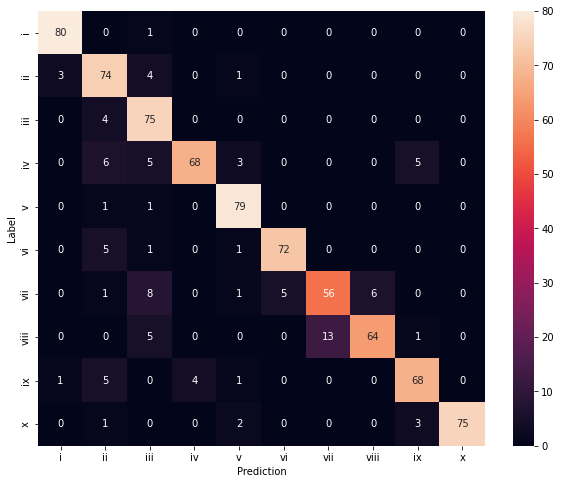

In [23]:
val_acc, val_cm = evaluate_model(model, valid)
print(f"Validation Accuracy: {val_acc}")
show_confusion_matrix(val_cm, labels)


7/7 [==============================] - 0s 6ms/step
Test Accuracy: 0.7884615384615384


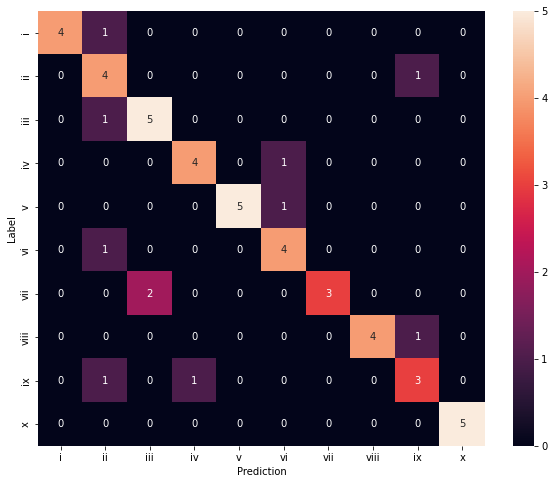

In [24]:
test_acc, test_cm = evaluate_model(model, test)
print(f"Test Accuracy: {test_acc}")
show_confusion_matrix(test_cm, labels)


## Track Data with DVC
We commit the new version of data with correct labels and augmented samples.

In [ ]:
!dvc add data

In [ ]:
!cat data.dvc

In [ ]:
!git add data.dvc
!git commit -m "add version_3 data"

In [ ]:
!dvc push

#Part 4 - Label Correction with Monte Carlo Dropout
When images are a few thousands, say 3k, it may be possible to do naive label correction. However, when we have samples in the order of tens of thousands, it becomes nearly impossible to go inspect all of them. 

To avoid going through all samples, we measure prediction uncertainty and only inspect samples with uncertainty above a selected threshold. To measure prediction uncertainty, we use [Monte-Carlo Dropout](https://docs.aws.amazon.com/prescriptive-guidance/latest/ml-quantifying-uncertainty/mc-dropout.html)


## Prediction Uncertainty
We add a monte-carlo dropout layer to the model and perform 50 prediction runs for each sample. We compute prediction uncertainty as the variance of logloss over 50 runs.

In [4]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import json
import sys
import pathlib
import os
import pandas as pd

batch_size = 8
tf.random.set_seed(123)

labels = ['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']

In [5]:
train_dir = pathlib.Path('data/train')
val_dir = pathlib.Path('data/val')
test_dir = pathlib.Path('label_book')

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

In [7]:
def create_dataset_df(ds):
  df = pd.DataFrame({"filenames": [filename.numpy().decode() for filename in ds]})
  df['label'] = df['filenames'].apply(lambda x: get_label(x).numpy())
  return df

In [8]:
class_names = np.array(sorted([item.name for item in train_dir.glob('*') if not item.name.startswith(".")])) #!= '.DS_Store'
print(class_names)

['i' 'ii' 'iii' 'iv' 'ix' 'v' 'vi' 'vii' 'viii' 'x']


In [9]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [32, 32])

def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [10]:
image_count = len(list(train_dir.glob('*/*.png')))

train_ds = tf.data.Dataset.list_files(str(train_dir/'*/*.png'), shuffle=False)
train_ds = train_ds.shuffle(image_count, reshuffle_each_iteration=False)
val_ds = tf.data.Dataset.list_files(str(val_dir/'*/*.png'), shuffle=False)
test_ds = tf.data.Dataset.list_files(str(test_dir/'*/*.png'), shuffle=False)


train_df = create_dataset_df(train_ds)
val_df = create_dataset_df(val_ds)
test_df = create_dataset_df(test_ds)

In [11]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
def configure_for_performance(ds, shuffle=False):
  ds = ds.cache()
  if shuffle:
    ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(8)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds, shuffle=True)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

In [13]:
class MonteCarloDropout(tf.keras.layers.Dropout):
    """Implementation of MonteCarlo Dropout"""

    def call(self, inputs):
        """Change training argument to default True"""
        return super().call(inputs, training=True)

In [14]:
class MyModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    base_model = tf.keras.applications.ResNet50(
    input_shape=(32, 32, 3),
    include_top=False,
    weights=None,
)
    base_model = tf.keras.applications.ResNet50(
        input_shape=(32, 32, 3),
        include_top=False,
        weights=None,
    )
    self.base_model = tf.keras.Model(
        base_model.inputs, outputs=[base_model.get_layer("conv2_block3_out").output]
    )
    self.dropout = MonteCarloDropout(0.5)
    self.dense1 = tf.keras.layers.Dense(10)

  def call(self, inputs):
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    x = self.base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = self.dropout(x)
    x = self.dense1(x)
    return x

  def predict_step(self, data):
      """Predict Step"""
      x, y = data

      pred_class_logits = []

      for _ in range(50):
          y_pred = self(x)
          pred_class_logits.append(y_pred)

      class_raw_logits = tf.stack(pred_class_logits, axis=1)
      pred_class_logits = tf.math.reduce_mean(tf.stack(pred_class_logits), axis=0)
      return pred_class_logits, y, class_raw_logits




In [15]:
model = MyModel()
model.build((1, 32, 32, 3))
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 8, 8, 256)         229760    
                                                                 
 monte_carlo_dropout (MonteC  multiple                 0         
 arloDropout)                                                    
                                                                 
 dense (Dense)               multiple                  2570      
                                                                 
Total params: 232,330
Trainable params: 229,386
Non-trainable params: 2,944
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [16]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "ckpt_part_4/best_model",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    save_weights_only=True,
)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[checkpoint, early_stopping],
)

Epoch 1/100
259/259 [==============================] - 14s 14ms/step - loss: 2.9212 - accuracy: 0.1374 - val_loss: 2.5908 - val_accuracy: 0.1538
Epoch 2/100
259/259 [==============================] - 2s 8ms/step - loss: 2.2900 - accuracy: 0.2651 - val_loss: 2.5449 - val_accuracy: 0.2374
Epoch 3/100
259/259 [==============================] - 2s 8ms/step - loss: 2.0317 - accuracy: 0.3372 - val_loss: 2.1913 - val_accuracy: 0.3124
Epoch 4/100
259/259 [==============================] - 2s 8ms/step - loss: 1.6820 - accuracy: 0.4286 - val_loss: 1.8745 - val_accuracy: 0.3998
Epoch 5/100
259/259 [==============================] - 2s 8ms/step - loss: 1.5361 - accuracy: 0.4717 - val_loss: 1.7924 - val_accuracy: 0.4391
Epoch 6/100
259/259 [==============================] - 2s 9ms/step - loss: 1.3639 - accuracy: 0.5360 - val_loss: 1.5631 - val_accuracy: 0.4674
Epoch 7/100
259/259 [==============================] - 2s 9ms/step - loss: 1.2481 - accuracy: 0.5747 - val_loss: 1.5520 - val_accuracy: 0.51

In [17]:
model.load_weights("ckpt_part_4/best_model")

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

def evaluate_model(model, dataset):
    labels = np.concatenate([y.numpy() for x, y in dataset], axis=0).argmax(axis=1)
    pred_labels = np.argmax(model.predict(dataset), axis=1)
    cm = confusion_matrix(labels, pred_labels)
    acc = accuracy_score(labels, pred_labels)
    return acc, cm

def show_confusion_matrix(cm, labels):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
                annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()

def evaluate_model2(model, ds, df):
  model_prediction = model.predict(ds)
  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction=tf.keras.losses.Reduction.NONE
  )
  loss = loss_fn(
      np.repeat(model_prediction[1][:, np.newaxis], axis=1, repeats=50),
      model_prediction[2],
  )
  loss_variance = np.var(loss, axis=1)
  predicted_labels = np.argmax(model_prediction[0], axis=1)
  cm = confusion_matrix(model_prediction[1], predicted_labels)
  acc = accuracy_score(model_prediction[1], predicted_labels)

  df.loc[:, "loss_variance"] = loss_variance
  df.loc[:, "predicted_label"] = predicted_labels
  df.loc[:, "label"] = model_prediction[1]
  return df, acc, cm

259/259 [==============================] - 22s 48ms/step
Train Accuracy: 0.9632317368166424


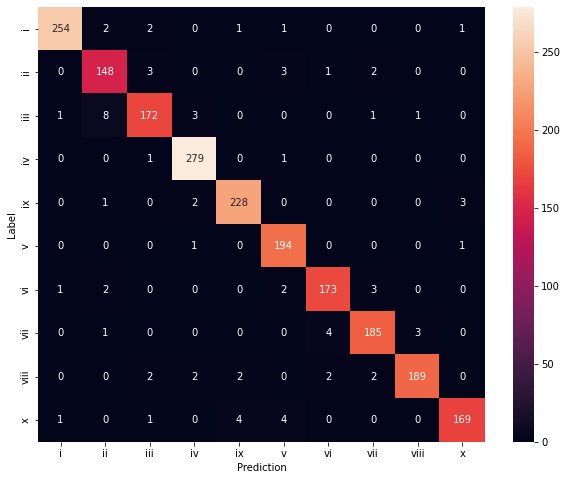

In [19]:
train_ds = tf.data.Dataset.list_files(str(train_dir/'*/*.png'), shuffle=False)
train_df = create_dataset_df(train_ds)
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
train_ds = configure_for_performance(train_ds, shuffle=False)


train_df, train_acc, train_cm = evaluate_model2(model, train_ds, train_df)
print(f"Train Accuracy: {train_acc}")
show_confusion_matrix(train_cm, labels)


102/102 [==============================] - 4s 38ms/step
Val Accuracy: 0.7183271832718328


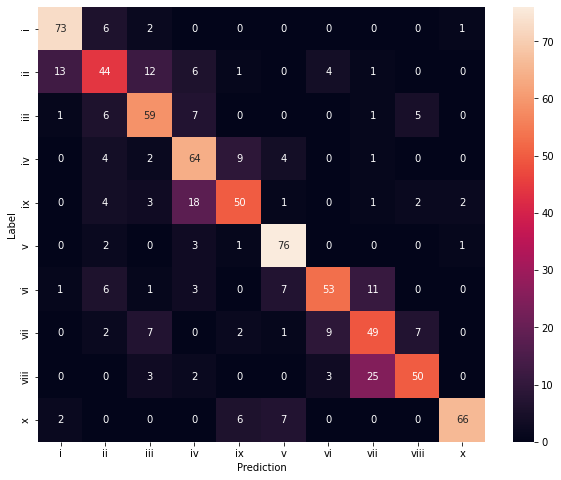

In [20]:
val_df, val_acc, val_cm = evaluate_model2(model, val_ds, val_df)
print(f"Val Accuracy: {val_acc}")
show_confusion_matrix(val_cm, labels)


7/7 [==============================] - 0s 48ms/step
Test Accuracy: 0.5576923076923077


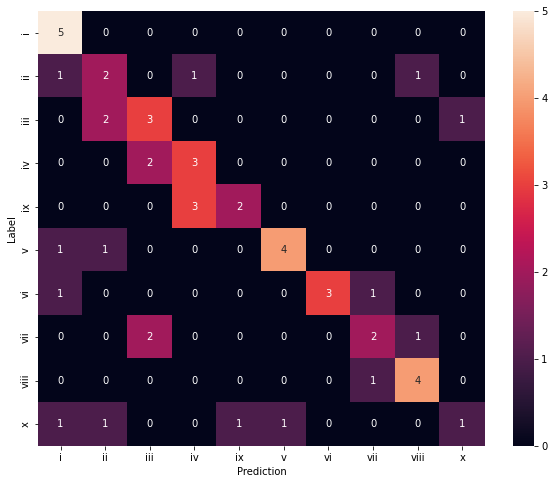

In [21]:
test_df, test_acc, test_cm = evaluate_model2(model, test_ds, test_df)
print(f"Test Accuracy: {test_acc}")
show_confusion_matrix(test_cm, labels)


In [22]:
test_df[test_df['loss_variance'] > 1.0]

,filenames,label,loss_variance,predicted_label
7,label_book/ii/a3b8f1fc-ce5d-11eb-b317-38f9d35e...,1,1.521194,8
18,label_book/iv/a6f8c07c-ce5d-11eb-b317-38f9d35e...,3,5.716460,2
21,label_book/ix/a7967416-ce5d-11eb-b317-38f9d35e...,4,1.792846,3
23,label_book/ix/a7ae10bc-ce5d-11eb-b317-38f9d35e...,4,3.027948,3
24,label_book/ix/a7dae376-ce5d-11eb-b317-38f9d35e...,4,1.007142,3
25,label_book/ix/a821f1a8-ce5d-11eb-b317-38f9d35e...,4,1.263406,4
26,label_book/v/a88a741c-ce5d-11eb-b317-38f9d35ea...,5,1.523610,1
28,label_book/v/a8d56ac6-ce5d-11eb-b317-38f9d35ea...,5,1.028805,0
32,label_book/vi/a2f7b186-ce5d-11eb-b317-38f9d35e...,6,1.498479,0
38,label_book/vii/a55094e8-ce5d-11eb-b317-38f9d35...,7,1.355349,2


In [23]:
train_df[['loss_variance']].describe()

,loss_variance
count,2.067000e+03
mean,1.103253e-01
std,2.075817e-01
min,1.442954e-08
25%,7.017246e-03
50%,3.509161e-02
75%,1.222691e-01
max,2.117602e+00


## Label Correction
We perform label correction by inspecting a subset of each dataset with prediction uncertainty above a selected threshold.

In [24]:
import os, glob, shutil
from PIL import Image
import matplotlib.pyplot as plt


import ipywidgets as widgets
from IPython.display import display
from ipywidgets import IntProgress, HTML, VBox, HBox

In [28]:
splits = {
    "train": train_df,
    "val": val_df,
    "test": test_df
}
path = None

def display_img(splits_dropdown, index, var_slider):
    global label, path
    df = splits[splits_dropdown]
    row = df[(df['loss_variance']>= var_slider[0]) & (df['loss_variance']<= var_slider[1])].iloc[index]
    path = row.filenames
    label.value = str(labels[row.label]) + "  " + f"loss_var: {row.loss_variance:.3f}"
    plt.figure(figsize=(8, 8), dpi=80)
    plt.imshow(Image.open(path), cmap='gray', vmin=0, vmax=255)
    plt.axis("off")
    plt.show()

next_button = widgets.Button(
    description='Next',
    disabled=False,
    button_style='success',
    tooltip='Next Sample',
    icon='arrow-right'
)

prev_button = widgets.Button(
    description='Previous',
    disabled=False,
    button_style='success',
    tooltip='Previous Sample',
    icon='arrow-left'
)
change_label_btn = widgets.Button(
    description='Change Label',
    disabled=False,
    button_style='success',
    tooltip='Change Label',
    icon='check'
)
delete_btn = widgets.Button(
    description='Delete',
    disabled=False,
    button_style='danger',
    tooltip='Delete',
    icon='fa-trash'
)
splits_dropdown = widgets.Dropdown(
    description='Splits',
    options=['train', 'val', 'test'],
    value='train',
    disabled=False,
)

index = widgets.IntSlider(
    value=0,
    min=0,
    max=len(splits[splits_dropdown.value])-1,
    step=1,
    description='Index:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

var_slider = widgets.FloatRangeSlider(
    value=[0, 10],
    min=0.0,
    max=10.0,
    description='Variance:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
)
  
label = widgets.Text(
    value='',
    placeholder='Label',
    description='Label:',
    disabled=False
)

new_label = widgets.Dropdown(
    description='New Label',
    options=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
    value='i',
    disabled=False,
)

ui_1 = widgets.HBox([prev_button, index, next_button, splits_dropdown, var_slider])
ui_2 = widgets.HBox([label, new_label, change_label_btn, delete_btn])
ui = widgets.VBox([ui_1, ui_2])

interactive_out = widgets.interactive_output(display_img, {"splits_dropdown":splits_dropdown, "index": index, "var_slider":var_slider})

def increment(_):
    with interactive_out:
        index.value+=1

def decrement(_):
    with interactive_out:
        index.value-=1

def change_label(_):
  new_path = path.split("/")
  new_path[-2] = new_label.value
  new_path = "/".join(new_path)
  shutil.move(path, new_path)

def delete_action(_):
    os.remove(path)

def update_index(_):
    df = splits[splits_dropdown.value]
    df = df[(df['loss_variance'] >= var_slider.value[0]) & (df['loss_variance']<= var_slider.value[1])]
    index.max = len(df)-1

splits_dropdown.observe(update_index)
var_slider.observe(update_index)

prev_button.on_click(decrement)
next_button.on_click(increment)
change_label_btn.on_click(change_label)
delete_btn.on_click(delete_action)

display(ui, interactive_out)

Output()

## Train and Evaluate

In [3]:
!rm -rf data
!mv data_label_corrected_mcd data

In [4]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import json
import sys
import os

In [5]:
train_val_directory = "data"
test_directory = "label_book"

batch_size = 8
tf.random.set_seed(123)

labels = ["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"]

### Data Augmentation
We apply same data augmentation used in part 1.

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import glob

datagen = ImageDataGenerator(
    rotation_range=30,          # randomly rotate image by upto 30 deg
    width_shift_range=0.2,      # randomly shift along x 
    height_shift_range=0.2,     # randomly shift along y
    zoom_range=0.1,             # zooming
    fill_mode='nearest')

for label in labels:
    i = 0
    input_dir = f'{train_val_directory}/train/{label}'
    image_list = glob.glob(f"{input_dir}/*.png")
    image_array = np.array([np.array(Image.open(image_name).resize((32, 32)))[:, :, np.newaxis] for image_name in image_list])
    out_dir = f'{train_val_directory}/train/{label}'
    os.makedirs(out_dir, exist_ok=True)
    max_images = len(image_array)*3
    for batch in datagen.flow(image_array, batch_size=batch_size,
                            save_to_dir= out_dir,
                            save_prefix='aug',
                            save_format='png'):    
        i+=len(batch)
        if i > max_images:
            break

In [7]:
train = tf.keras.preprocessing.image_dataset_from_directory(
    train_val_directory + '/train',
    labels="inferred",
    label_mode="categorical",
    class_names=labels,
    shuffle=True,
    seed=123,
    batch_size=batch_size,
    image_size=(32, 32),
)

valid = tf.keras.preprocessing.image_dataset_from_directory(
    train_val_directory + '/val',
    labels="inferred",
    label_mode="categorical",
    class_names=labels,
    shuffle=False,
    seed=123,
    batch_size=batch_size,
    image_size=(32, 32),
)

total_length = ((train.cardinality() + valid.cardinality()) * batch_size).numpy()
if total_length > 10_000:
    print(f"Dataset size larger than 10,000. Got {total_length} examples")
    sys.exit()

test = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory,
    labels="inferred",
    label_mode="categorical",
    class_names=labels,
    shuffle=False,
    seed=123,
    batch_size=batch_size,
    image_size=(32, 32),
)

Found 7651 files belonging to 10 classes.
Found 803 files belonging to 10 classes.
Found 52 files belonging to 10 classes.


In [8]:
base_model = tf.keras.applications.ResNet50(
    input_shape=(32, 32, 3),
    include_top=False,
    weights=None,
)
base_model = tf.keras.Model(
    base_model.inputs, outputs=[base_model.get_layer("conv2_block3_out").output]
)

inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.applications.resnet.preprocess_input(inputs)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(10)(x)
model = tf.keras.Model(inputs, x)

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 tf.__operators__.getitem (S  (None, 32, 32, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 32, 32, 3)        0         
                                                                 
 model (Functional)          (None, 8, 8, 256)         229760    
                                                                 
 global_average_pooling2d (G  (None, 256)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 10)                2570

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "ckpt_part_4_2/best_model",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    save_weights_only=True,
)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

history = model.fit(
    train,
    validation_data=valid,
    epochs=100,
    callbacks=[checkpoint],
)

Epoch 1/100
957/957 [==============================] - 35s 23ms/step - loss: 1.7479 - accuracy: 0.3849 - val_loss: 1.6956 - val_accuracy: 0.4284
Epoch 2/100
957/957 [==============================] - 11s 11ms/step - loss: 1.1893 - accuracy: 0.6032 - val_loss: 0.9704 - val_accuracy: 0.6800
Epoch 3/100
957/957 [==============================] - 11s 11ms/step - loss: 0.9081 - accuracy: 0.7000 - val_loss: 1.0002 - val_accuracy: 0.6501
Epoch 4/100
957/957 [==============================] - 10s 11ms/step - loss: 0.7543 - accuracy: 0.7492 - val_loss: 0.8963 - val_accuracy: 0.6899
Epoch 5/100
957/957 [==============================] - 11s 12ms/step - loss: 0.6501 - accuracy: 0.7915 - val_loss: 0.9556 - val_accuracy: 0.6737
Epoch 6/100
957/957 [==============================] - 11s 11ms/step - loss: 0.5648 - accuracy: 0.8192 - val_loss: 0.6373 - val_accuracy: 0.7945
Epoch 7/100
957/957 [==============================] - 11s 11ms/step - loss: 0.4975 - accuracy: 0.8424 - val_loss: 0.5437 - val_ac

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

def evaluate_model(model, dataset):
    labels = np.concatenate([y.numpy() for x, y in dataset], axis=0).argmax(axis=1)
    pred_labels = np.argmax(model.predict(dataset), axis=1)
    cm = confusion_matrix(labels, pred_labels)
    acc = accuracy_score(labels, pred_labels)
    return acc, cm

def show_confusion_matrix(cm, labels):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
                annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()

In [11]:
model.load_weights("ckpt_part_4_2/best_model")

101/101 [==============================] - 1s 7ms/step
Validation Accuracy: 0.8966376089663761


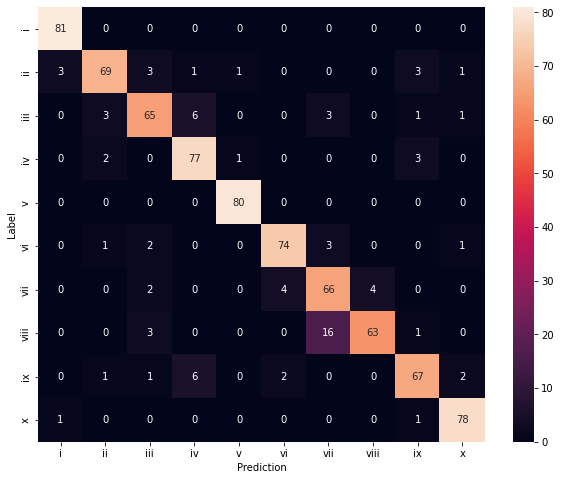

In [12]:
val_acc, val_cm = evaluate_model(model, valid)
print(f"Validation Accuracy: {val_acc}")
show_confusion_matrix(val_cm, labels)


7/7 [==============================] - 0s 19ms/step
Test Accuracy: 0.7115384615384616


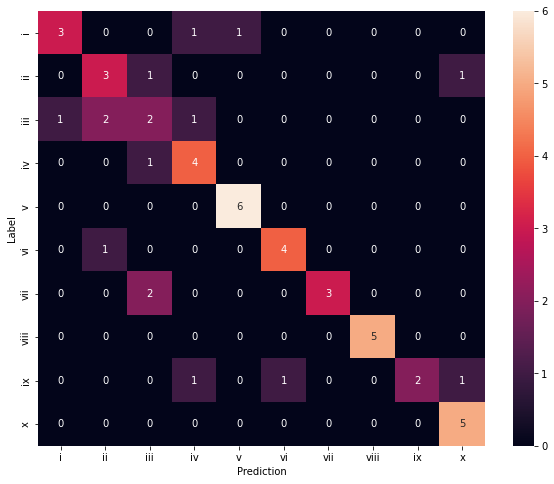

In [13]:
test_acc, test_cm = evaluate_model(model, test)
print(f"Test Accuracy: {test_acc}")
show_confusion_matrix(test_cm, labels)


## Track Data with DVC
We commit the new version of data with correct labels and augmented samples.

In [ ]:
!dvc add data

In [ ]:
!cat data.dvc

In [ ]:
!git add data.dvc
!git commit -m "add version_4 data"

In [ ]:
!dvc push